In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
from matplotlib import rc
from mpl_toolkits.basemap import Basemap
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
class ParticleData(object):
    def __init__(self):
        self.id = []
        self.ends = []

    def trajends(self):
        lonends = [self.lon[i,self.ends[i]] for i in range(self.lon.shape[0])]
        latends = [self.lat[i,self.ends[i]] for i in range(self.lat.shape[0])]
        return lonends, latends

def load_particles_file(fname, varnames):
    T = ParticleData()
    pfile = Dataset(fname, 'r')
    T.id = pfile.variables['trajectory'][:]

    if 'trajectory' in pfile.dimensions:  # file in array format
        for v in varnames:
            if v is 'startloc':
                setattr(T, v, pfile.variables[v][:,0])
            else:
                setattr(T, v, pfile.variables[v][:])
        nid = T.lon.shape[0]
        nobs = T.lon.shape[1]
        T.ends = np.empty((nid, 1), dtype=np.int)
        for i in range(nid):
            I = np.nonzero(T.age[i,:])[0]
            I = nobs+1 if I.size==0 else I[0]
            T.lon[i,0:I-1] = np.nan
            T.lat[i,0:I-1] = np.nan            
            if np.isnan(T.lon[i,:]).any():
                T.ends[i] = np.where(np.isnan(T.lon[i,:]))[0][0]-1
            else:
                T.ends[i] = T.lon.shape[-1]-1
    T.time_origin = datetime.datetime(1900, 12, 31)
    return T

In [3]:
Ts = {}
for s, marker, name, color in zip([38, 40], ['s','o'], ['EAC', 'Coastal'], ['C0', 'C1']):
    Ts[s] = load_particles_file('microbes_eac_hycom_particles'+str(s)+'.nc', ['lon', 'lat', 'temp', 'age', 'time'])
    Ts[s].time = np.ma.filled(np.mean(Ts[s].time,0), np.nan)
    Ts[s].time = [Ts[s].time_origin + datetime.timedelta(seconds=Ts[s].time[t]) for t in range(Ts[s].time.size)]
    Ts[s].marker = marker
    Ts[s].name = name
    Ts[s].color = color

In [4]:
pylab.rcParams['figure.figsize'] = (14, 8)
def makemov(Ts):
    fig = plt.figure()

    frames = np.arange(0, len(Ts[38].time))
    
    minlon = min([np.amin(Ts[z].lon) for z in Ts])
    maxlon = max([np.amax(Ts[z].lon) for z in Ts])
    minlat = min([np.amin(Ts[z].lat) for z in Ts])
    maxlat = max([np.amax(Ts[z].lat) for z in Ts])
    mintemp = min([np.amin(Ts[z].temp) for z in Ts])
    maxtemp = max([np.amax(Ts[z].temp) for z in Ts])
    
    
    def setmap(i, T):
        ax = fig.add_subplot(1, len(Ts), i+1)
        ttl = ax.set_title(Ts[z].name + ' particles on ' + T.time[frames[0]].strftime("%Y-%m-%d"))
        m = Basemap(projection='cea', ax=ax, llcrnrlat=minlat-1, urcrnrlat=maxlat+1,\
                    llcrnrlon=minlon-1, urcrnrlon=maxlon+1, resolution='i')
        m.drawcoastlines()
        m.fillcontinents(color='burlywood')
        xs, ys = m(T.lon[:, frames[0]], T.lat[:, frames[0]])
        m.scatter(xs, ys, c='r', s=100, edgecolor='k')
        return m, ttl
    
    def setscat(T, m):
        xs, ys = m(T.lon[:, frames[0]], T.lat[:, frames[0]])
        scat = m.scatter(xs, ys, c=T.temp[:, frames[0]], s=45, edgecolor='k', marker=Ts[z].marker)
        scat.set_clim([mintemp, maxtemp])
        plt.colorbar(scat, orientation='horizontal')
        return scat

    m = {}
    scat = {}
    ttl = {}
    for i, z in enumerate(Ts):
        m[z], ttl[z] = setmap(i, Ts[z])
        scat[z] = setscat(Ts[z], m[z])
    
    def animate(t):
        for z in Ts:
            scat[z].set_offsets(np.matrix(m[z](Ts[z].lon[:, t], Ts[z].lat[:, t])).transpose())
            scat[z].set_array(Ts[z].temp[:, t])
            ttl[z].set_text(Ts[z].name + ' particles on ' + Ts[z].time[t].strftime("%Y-%m-%d"))
        return scat

    rc('animation', html='html5')
    anim = animation.FuncAnimation(fig, animate, frames=frames,
                                   interval=100, blit=False)
    plt.close()
    return anim

makemov(Ts)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


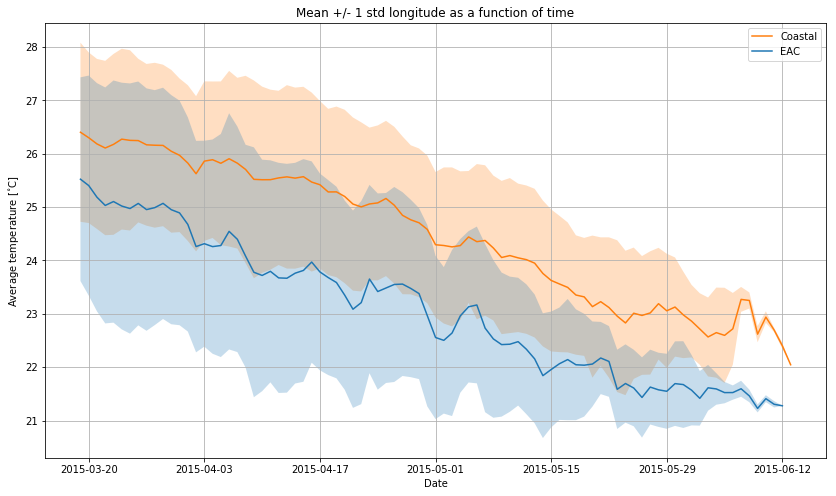

In [5]:
for z in Ts:
    mn = np.nanmean(Ts[z].temp, 0)
    st = np.nanstd(Ts[z].temp, 0)
    plt.plot(Ts[z].time, mn, label=Ts[z].name, color=Ts[z].color)
    plt.fill_between(Ts[z].time, mn-st, mn+st, alpha=0.25, facecolor=Ts[z].color)

plt.ylabel('Average temperature [$^{\circ}$C]')
plt.xlabel('Date')
plt.title('Mean +/- 1 std longitude as a function of time')
plt.legend()
plt.grid()
plt.show()